# Statistical forecast

This notebook runs some statistics methods the  `coinmarketcap.csv`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from math import sqrt
from holtwinters import simple_exp_smoothing, holt #ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from pyramid.arima import auto_arima, ARIMA

/home/dahuebi/PML/cas-pml-prj/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Import code from *data preprocessing* notebook

In [2]:
import ipynb.fs  # Boilerplate required
# only import defnitions
from .defs.data_preprocessing import loadCoinMarketCap

## Load historical data into a dataframe

In [3]:
df = loadCoinMarketCap(
    minSamples   = 180, # only consider coins having at least half a year of samples
    minMarketCap = 1*1000*1000*1000, # 1 billion
    minVolume    = 1*1000*1000*1000, # 1 billion
)
# some constants
COL_VOLUME = "volume"
COL_MARKET = "marketcap"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
COL_OHLC   = "ohlc_average"
print(df.head())
print("Currencies: {}".format(df[COL_NAME].unique()))
# df = df.loc[df.index.year < 2018]
WINDOW = 30  # 30 day forecast window

Samples filled: 5
Loaded 13 currencies, 10649 samples.
               slug name    open    high     low   close  volume     marketcap
date                                                                          
2013-04-28  bitcoin  BTC  135.30  135.98  132.10  134.21     0.0  1.500520e+09
2013-04-29  bitcoin  BTC  134.44  147.49  134.00  144.54     0.0  1.491160e+09
2013-04-30  bitcoin  BTC  144.00  146.93  134.05  139.00     0.0  1.597780e+09
2013-05-01  bitcoin  BTC  139.00  139.89  107.72  116.99     0.0  1.542820e+09
2013-05-02  bitcoin  BTC  116.38  125.60   92.28  105.21     0.0  1.292190e+09
Currencies: ['BTC' 'ETH' 'XRP' 'BCH' 'LTC' 'XLM' 'NEO' 'MIOTA' 'ETC' 'QTUM' 'EOS'
 'USDT' 'SNT']


## Helper functions

In [4]:
def filterCurrency(df, name):
    """
    Filter currency by name out of data frame
    """
    return df.loc[df.name == name]# calculate ohlc average

In [5]:
def addOhlvAverage(df):
    """
    Calculate Open, High, Low, Close average
    """
    dfAvg = pd.DataFrame()
    dfAvg[COL_OHLC] = (df[COL_OPEN] + df[COL_HIGH] +
                          df[COL_LOW] + df[COL_CLOSE]) / 4
    return dfAvg

In [6]:
def calculateRMSE(test, yHat):
    """
    Calcuate root meas squared error
    """
    forecast = yHat.iloc[:, 1]
    rmse = sqrt(mean_squared_error(test[COL_OHLC],forecast))
    return rmse

## Forecast functions

In [7]:
def naiveForecast(train, test):
    """
    Forcast based on lastest value value
    """
    name = "Naive Forecast"
    dd = np.asarray(train[COL_OHLC])
    yHat = test.copy()
    yHat['forecast'] = dd[len(dd) - 1]
    rmse = calculateRMSE(test, yHat)
    return name, rmse, yHat

In [8]:
def simpleAverageForecast(train, test):
    """
    Forecast based on simple average
    """
    name = "Average Forecast"
    yHat = test.copy()
    yHat["forecast"] = train[COL_OHLC].mean()
    rmse = calculateRMSE(test, yHat)
    return name, rmse, yHat

In [9]:
def movingAverageForecast(train, test, window=WINDOW):
    """
    Forecast based on moving average over window period
    """
    name = "Moving Average Forecast"
    yHat = test.copy()
    yHat["forecast"] = train[COL_OHLC].rolling(window).mean().iloc[-1]
    rmse = calculateRMSE(test, yHat)
    return name, rmse, yHat

In [10]:
def simpleExponentialSmoothingForecast(train, test, level=0.6):
    """
    Forecast based on Simple Exponential Smoothing
    """
    name = "Simple Exponential Smoothing"
    yHat = test.copy()
    yHat["forecast"] = simple_exp_smoothing(
        np.asarray(train[COL_OHLC]),
        h = len(test)
    ).fcast
    rmse = calculateRMSE(test, yHat)
    return name, rmse, yHat

In [11]:
def holtForecast(train, test):
    name = "Holt"
    # sm.tsa.seasonal_decompose(train[COL_OHLC]).plot()
    # result = sm.tsa.stattools.adfuller(train[COL_OHLC])
    yHat = test.copy()
    yHat["forecast"] = holt(np.asarray(train[COL_OHLC]),
            h=len(test)).fcast
    rmse = calculateRMSE(test, yHat)
    return name, rmse, yHat

In [12]:
def arimaForecast(train, test):
    """
    Forecast based on AutoRegressive Integrated Moving Average
    """
    name = "ARIMA Forecast"
    yHat = test.copy()
    modle = None
    if True:  # auto_arima
        model = auto_arima(np.asarray(train[COL_OHLC]),
                start_p=1,
                start_q=1,
                max_p=3,
                max_q=3,
                m=12,
                start_P=0,
                seasonal=True,
                #d=1,
                #D=1,
                trace=True,
                approximation=True,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True)
        print(model.summary())
    else: # ARMIA with prefilled parameters
        model = ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 2, 3),
                    out_of_sample_size=0, scoring='mse', scoring_args={},
                    seasonal_order=(0, 0, 2, 12), solver='lbfgs', start_params=None,
                    suppress_warnings=True, transparams=True, trend='c')
        model.fit(np.asarray(train[COL_OHLC]))
    yHat["forecast"] = model.predict(len(test))
    rmse = calculateRMSE(test, yHat)
    return name, rmse, yHat

## Execute all forecasts and plot the result

In [13]:
def forecastCoin(df, name=""):
    dfCoin = filterCurrency(df, name)
    dfCoin = addOhlvAverage(dfCoin)

    # split data into train and test data
    Xtrain = dfCoin.iloc[:-WINDOW, :]
    Xtest = dfCoin.iloc[-WINDOW:, :]

    # forecast functions
    forecastFunctions = [
            naiveForecast,
            simpleAverageForecast,
            movingAverageForecast,
            simpleExponentialSmoothingForecast,
            holtForecast,
            #arimaForecast,
    ]

    # prepare plot
    totalPlots = len(forecastFunctions) + 1
    fig, axarr = plt.subplots((totalPlots + 1) // 2, 2, figsize=(20, (totalPlots // 2) * 6))
    fig.suptitle(name)

    # plot train/test data
    ax = axarr[0, 0]
    ax.plot(Xtrain, label="Train")
    ax.plot(Xtest, label="Test")
    ax.legend(loc="best")
    ax.set_title("Train/Test Data")

    # run all forecast functions and plot result
    for idx, forecastFunc in enumerate(forecastFunctions):
        idx = idx + 1
        name, rmse, yHat = forecastFunc(Xtrain, Xtest)
        forecast = yHat.iloc[:, 1]
        ax = axarr[idx // 2, idx % 2]
        ax.plot(Xtrain.index, Xtrain[COL_OHLC], label="Train")
        ax.plot(Xtest.index, Xtest[COL_OHLC], label="Test")
        ax.plot(yHat.index, forecast, label=name)
        ax.legend(loc="best")
        ax.set_title("{} RMSE: {:0.2f}".format(name, rmse))

    # Tight layout often produces nice results
    # but requires the title to be spaced accordingly
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

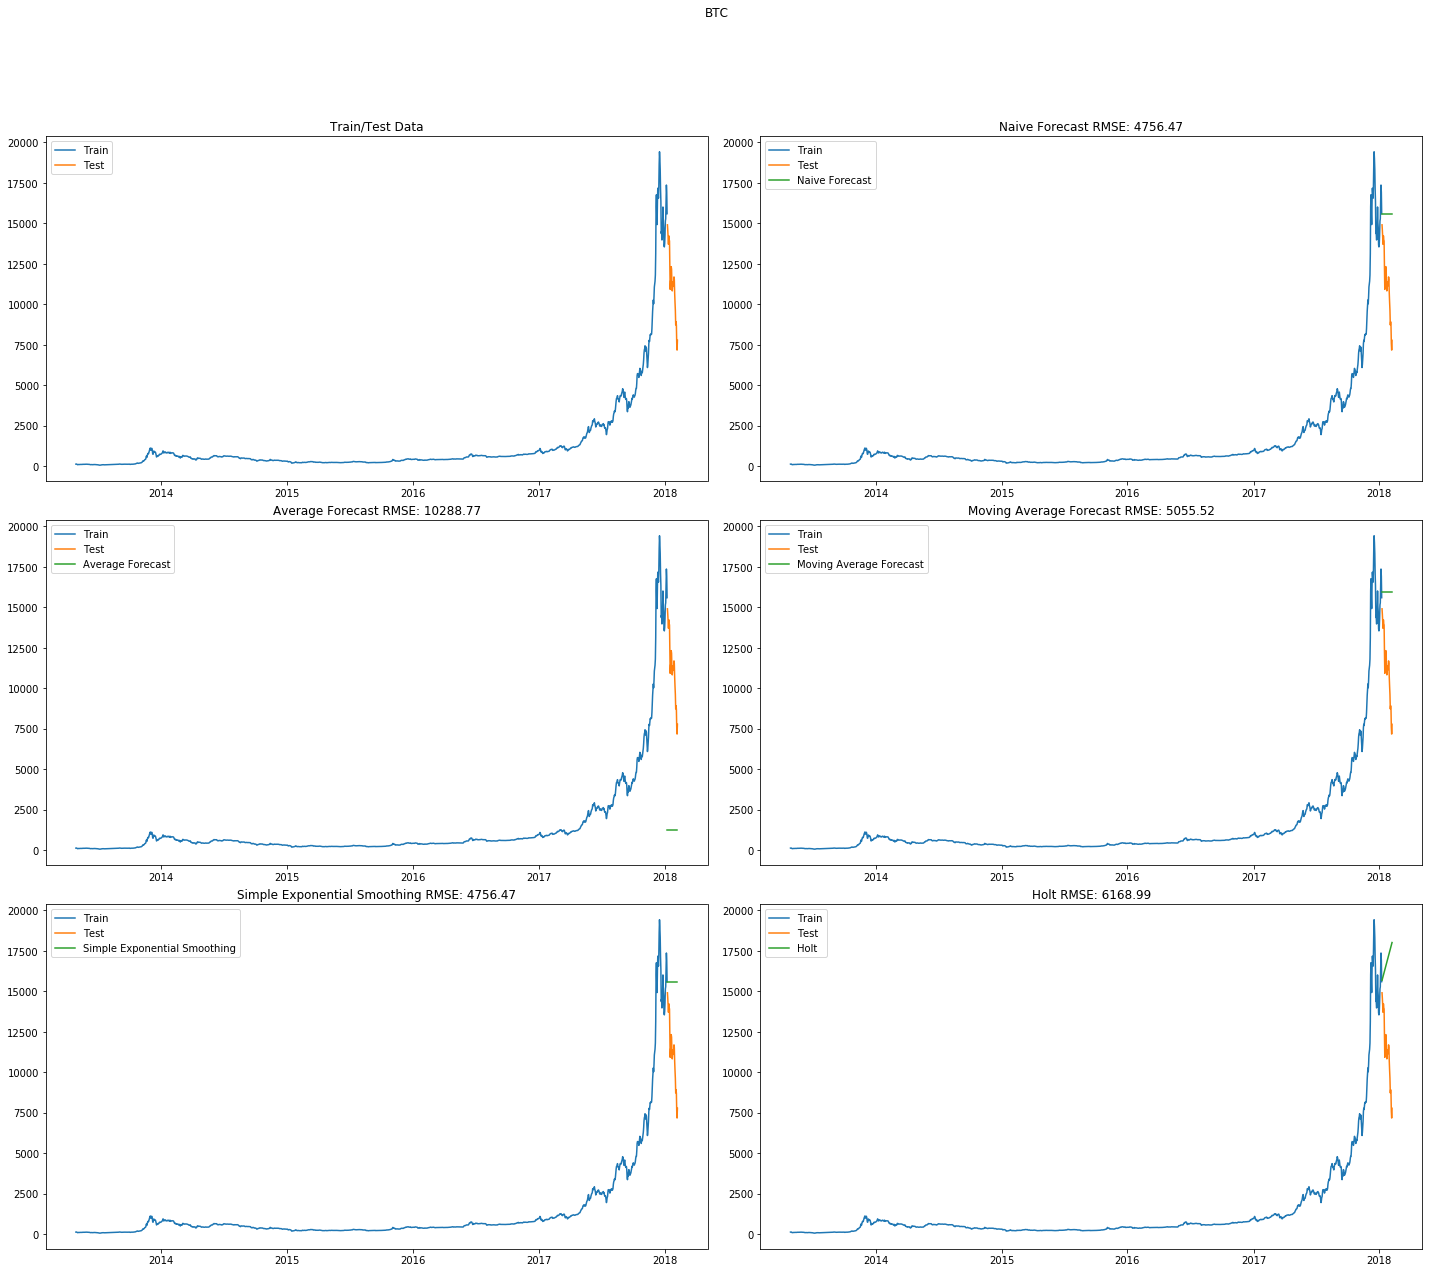

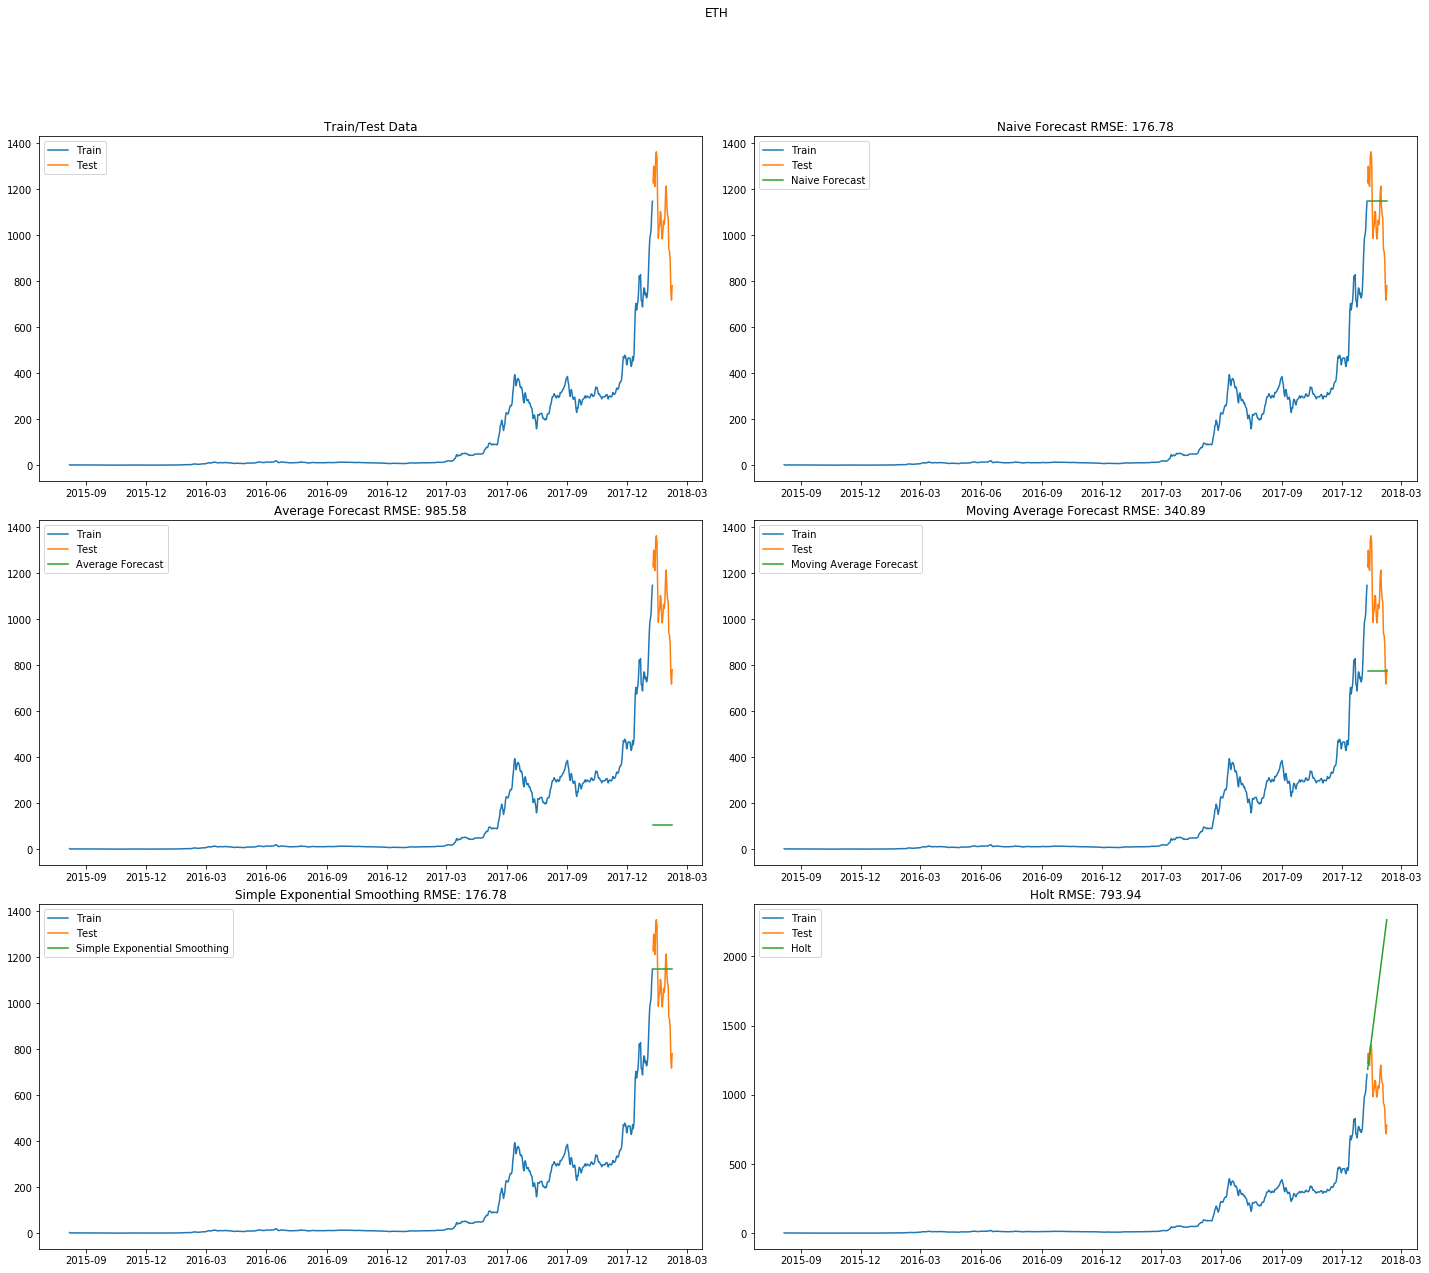

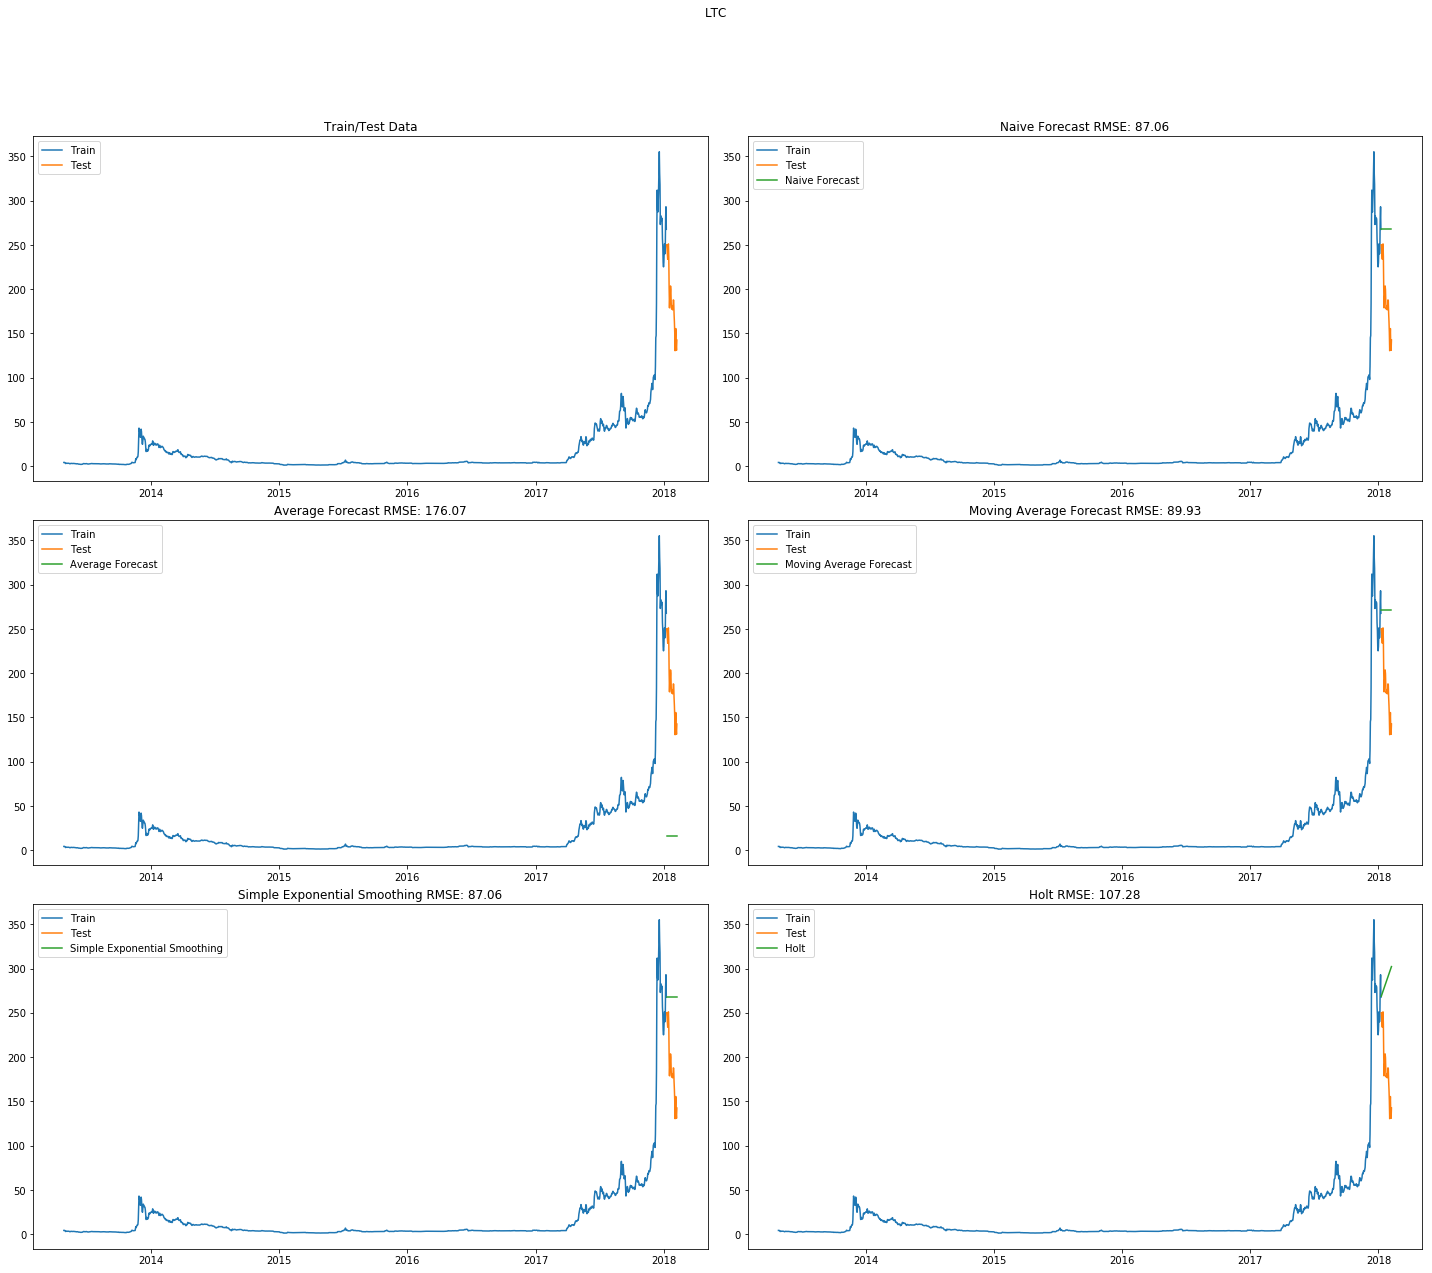

In [14]:
for name in ["BTC", "ETH", "LTC"]:
    forecastCoin(df, name=name)